# **Final Model Evaluation**

The results presented in this notebook should not be interpreted in absolute terms. The overall performance of the models appears suboptimal because we deliberately removed the `prev_stop_delay` feature, which was highly correlated with the target variable. This decision was made to better isolate and analyze the impact of incorporating topological features derived from the railway network.

The primary objective of this evaluation is **not** to develop the best predictive model for train delays, but rather to **compare the relative performance of different models** trained on various dataset configurations. By doing so, we can assess whether integrating structural information extracted from the network improves predictive accuracy.

The following models are compared:

- **ElasticNet (Base & Graph)** – A simple linear regression with L1 and L2 regularization, serving as a baseline.
- **XGBoost (Base, Graph, Embedding)** – A more powerful gradient boosting model to capture non-linear relationships.
- **LSTM (Base, Graph, Embedding)** – A recurrent neural network designed to capture temporal dependencies.

The evaluation will focus on three key metrics:

- **Root Mean Squared Error (RMSE)**: Measures overall prediction error, with lower values indicating better performance.
- **Mean Absolute Error (MAE)**: Provides an intuitive sense of average prediction error magnitude.
- **R^2 Score**: Assesses how well the model explains variance in the target variable.

By comparing these metrics across models, we can determine whether the addition of graph-based features or embeddings leads to a meaningful improvement in predictive performance.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
RESULTS_PATH = Path("results")

files = [
    ("elasticnet_gridsearch_results_base.csv", "ElasticNet Base"),
    ("elasticnet_gridsearch_results_graph.csv", "ElasticNet Graph"),
    ("xgb_results_base.csv", "XGB Base"),
    ("xgb_results_graph.csv", "XGB Graph"),
    ("xgb_results_embeddings.csv", "XGB Embedding"),
    ("lstm_results_base.csv", "LSTM Base"),
    ("lstm_results_graph.csv", "LSTM Graph"),
    ("lstm_results_graph_embedding.csv", "LSTM Embedding")
]

In [22]:
results = []
for file, model in files:
    try:
        df = pd.read_csv(RESULTS_PATH / file)
        rmse = df['RMSE'].mean()
        mae = df['MAE'].mean()
        r2_column = 'R^2' if 'R^2' in df.columns else 'R²'
        r2 = df[r2_column].mean()
        results.append([model, rmse, mae, r2])
    except Exception as e:
        print(f"Error loading {file}: {e}")

results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R^2"])
results_df.sort_values(by="RMSE", ascending=True, inplace=True)  # Sort by RMSE

,Model,RMSE,MAE,R^2
3,XGB Graph,5.409420,2.512164,0.486971
2,XGB Base,5.473275,2.551569,0.474788
4,XGB Embedding,5.540540,2.571992,0.461799
6,LSTM Graph,5.930868,2.801574,0.436863
7,LSTM Embedding,5.958808,2.866467,0.431545
5,LSTM Base,6.019381,2.894840,0.419929
1,ElasticNet Graph,6.129711,3.030111,0.345329
0,ElasticNet Base,6.133966,3.038087,0.344419


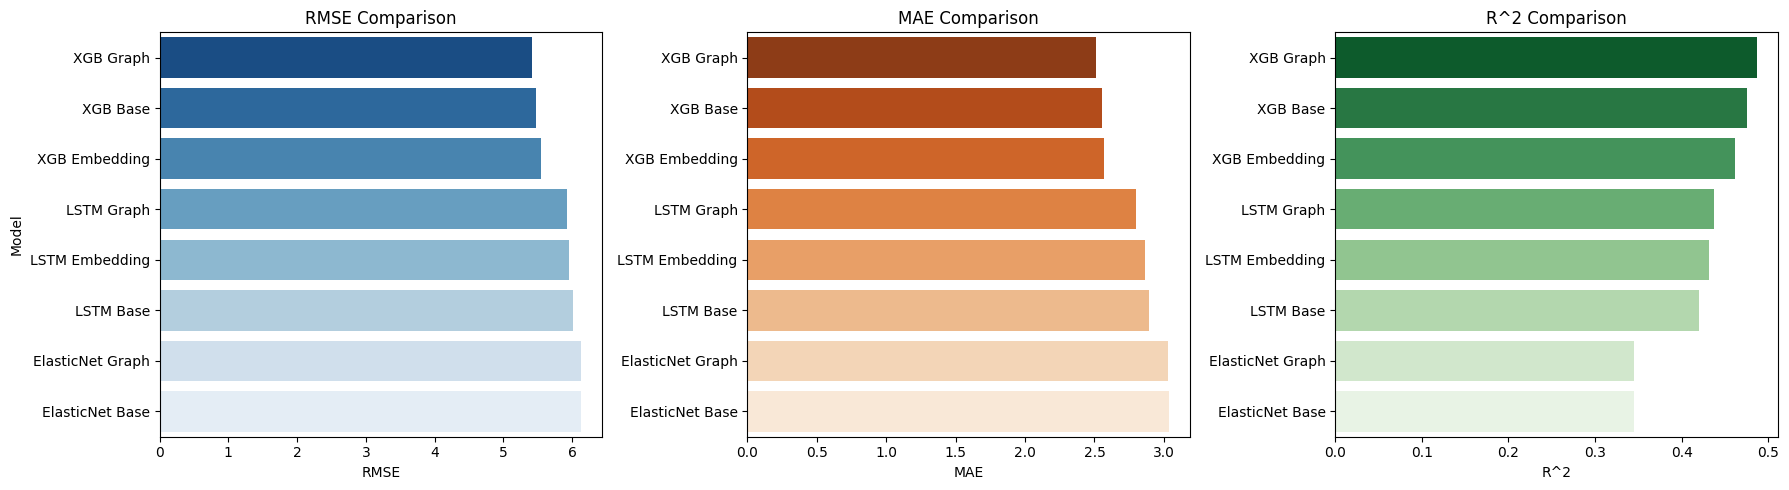

In [23]:
display(results_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(ax=axes[0], data=results_df, x="RMSE", y="Model", hue="Model", dodge=False, palette="Blues_r", legend=False)
axes[0].set_title("RMSE Comparison")
axes[0].set_xlabel("RMSE")
axes[0].set_ylabel("Model")

sns.barplot(ax=axes[1], data=results_df, x="MAE", y="Model", hue="Model", dodge=False, palette="Oranges_r", legend=False)
axes[1].set_title("MAE Comparison")
axes[1].set_xlabel("MAE")
axes[1].set_ylabel("")

sns.barplot(ax=axes[2], data=results_df, x="R^2", y="Model", hue="Model", dodge=False, palette="Greens_r", legend=False)
axes[2].set_title("R^2 Comparison")
axes[2].set_xlabel("R^2")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

## **Conclusion**

The evaluation results confirm that incorporating structural information from the railway network has a positive impact on predictive performance. However, the magnitude of improvement varies depending on the model type and the way graph-based features are integrated.

1. **XGBoost Consistently Outperforms Other Models**  
   The best-performing model is **XGBoost with graph-based features**, achieving the lowest RMSE (5.409) and the highest R^2 (0.487). This suggests that XGBoost effectively captures non-linear interactions between topological features and train delays.  
   - The **Base XGBoost model** performs slightly worse (RMSE: 5.473, R^2: 0.475), but the difference indicates that structural features provide additional predictive power.  
   - The **XGBoost model trained with Node2Vec embeddings** performs worse than the graph-based feature model (RMSE: 5.541, R^2: 0.462), suggesting that direct structural features are more effective than unsupervised node embeddings in this context.

2. **LSTM Performance Improves with Graph-Based Features**  
   The **Graph LSTM** model (RMSE: 5.931, R^2: 0.437) outperforms both the Base LSTM (RMSE: 6.019, R^2: 0.420) and the Embedding LSTM (RMSE: 5.959, R^2: 0.432). While the improvements are moderate, they indicate that including explicit graph-based features benefits recurrent neural networks in capturing delay propagation patterns.

3. **ElasticNet Shows Limited Improvement**  
   The **ElasticNet model**, which serves as a linear baseline, benefits the least from additional structural features. Both the Base and Graph versions achieve similar results (R^2 around 0.345), reinforcing the idea that linear models struggle to leverage topological information effectively.

So, the final considerations we can draw from the results of the experiments conducted so far are:
- **Graph-based features extracted from the railway network provide a clear advantage over using only standard tabular data.** This effect is most evident in XGBoost and, to a lesser extent, in LSTM models.
- **Node2Vec embeddings do not outperform direct graph-based features.** While they capture network structure, they may not encode information in the most optimal way for time-series forecasting.
- **Non-linear models like XGBoost benefit the most from graph-based enhancements,** while LSTMs show moderate improvements and linear models see minimal gains.

These findings suggest that future work should explore alternative ways of integrating graph embeddings, such as using domain-specific constraints in the embedding process or incorporating Graph Neural Networks (GNNs) to learn more meaningful representations of the railway topology.

> Note: A promising direction for future research is the integration of **exogenous information**, such as weather conditions, which could significantly impact train delays. Preliminary experiments in this direction had to be halted due to the high volume of data required via API requests, which would have taken several days to collect. However, if this limitation can be overcome, weather variables (e.g., precipitation, temperature, wind speed) could provide valuable context to further refine delay predictions.